## Crawling [CIKRF](http://www.vybory.izbirkom.ru/region/region/izbirkom?action=show&root=1&tvd=100100084849066&vrn=100100084849062&region=0&global=true&sub_region=0&prver=0&pronetvd=null&vibid=100100084849066&type=227) website

In [1]:
import os, re, xlrd, pickle, requests, warnings, lxml.html
import numpy as np

from transliterate import translit

In [182]:
def normalize_string(string, to_strip=True,
                     to_rm_chars=",)('",
                     to_replace_patterns=((' ', '_'), ('№', '#'), ('_-_', '-')),
                     to_translit=True):

    # whitespace characters stripping
    if to_strip:
        string = string.strip()

    # transliteration
    if to_translit:
        string=translit(string, reversed=True)

    # characters removing
    if to_rm_chars:
        for c in to_rm_chars:
            string = string.replace(c, '')

    # substrings replacing
    if to_replace_patterns:
        for pattern in to_replace_patterns:
            string = string.replace(pattern[0], pattern[1])

    return string

def get_table_from_page(page, table_position=2, is_local_page=False, is_to_use_xls=False):
    if not is_to_use_xls:
        page_tree = lxml.html.document_fromstring(page.text)
        table = page_tree.xpath('/html/body/table[{}]/tr[4]/td/table[6]'.format(str(table_position)))[0]

        # first column
        sum_key = 'Total'

        value = []
        for el in table.xpath('tr/td[1]/table')[0][1:13]:
            value.append(int(el[2].text_content()))
        for el in table.xpath('tr/td[1]/table')[0][14:]:
            value.append(int(el[2].text_content().split('\n')[0].strip()))

        # other columns
        lowlvl_keys = []
        lowlvl_table_links = {}

        for el in table.xpath('tr/td[2]/div/table/tr[1]')[0]:
            if is_local_page:
                new_key = normalize_string(el.xpath('nobr')[0].text_content())
            else:
                link = el.xpath('nobr/a')[0]
                new_key = normalize_string(link.text_content())
                lowlvl_table_links[new_key] = link.get('href')
            lowlvl_keys.append(new_key)

        values = [[] for i in range(20)]
        count = 0
        for el in table.xpath('tr/td[2]/div/table')[0][1:13]:
            for sub_el in el:
                values[count].append(int(sub_el.text_content().strip()))
            count += 1
        for el in table.xpath('tr/td[2]/div/table')[0][14:]:
            for sub_el in el:
                values[count].append(int(sub_el.text_content().split('\n')[0].strip()))
            count += 1

        # concatenating columns
        keys = [sum_key] + lowlvl_keys

        for i in range(20):
            values[i] = tuple([value[i]] + values[i])

        # making table
        dt = list(zip(keys, ['<i4'] * len(keys)))
        table = np.array(values, dtype=dt)

    else:
        warnings.warn('\nEnabling using XLS files leads to additional network requests as XLS file should be retrieved from the server.\nIt is better to avoid using this option.')
        temp_filename = "temp.xls"
        xls_file_link = get_xls_table_link(page)
        r = requests.get(xls_file_link)
        with open(temp_filename, "wb") as file:
            file.write(r.content)
        table = get_table_from_xls(temp_filename)
        os.remove(temp_filename)
        lowlvl_table_links, lowlvl_keys = None, None

    assert(check_table(table))

    return table, lowlvl_table_links, lowlvl_keys

def get_table_from_xls(filename):
    xls = xlrd.open_workbook(filename, formatting_info=True)
    sheet = xls.sheet_by_index(0)

    uiks_num = int(sheet.cell(7, 2).value)

    keys = ['Total']
    for col_num in range(3, 3 + uiks_num):
        keys.append(normalize_string(sheet.cell(10, col_num).value))

    values = [[] for i in range(20)]
    count = 0
    for row_num in range(11, 23):
        for col_num in range(2, 3 + uiks_num):
            values[count].append(int(sheet.cell(row_num, col_num).value))
        count += 1
    for row_num in range(24, 39, 2):
        for col_num in range(2, 3 + uiks_num):
            values[count].append(int(sheet.cell(row_num, col_num).value))
        count += 1

    values = list(map(tuple, values))

    # making table
    dt = list(zip(keys, ['<i4'] * len(keys)))
    table = np.array(values, dtype=dt)
    # checks table itself
    assert(check_table(table))

    return table

def check_table(table):
    #table = lvl0_table.view(np.int32).reshape(20, -1) TODO
    #table = np.concatenate(tuple(table[name].reshape(20, 1) for name in table.dtype.names), axis=1)
    table = np.transpose(np.array([list(table[name]) for name in table.dtype.names]))
    check = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                      [0, 0, 0, 0, 0, 0, -1, -1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, -1, 1, 1, 1, 1, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0]],
                     dtype=np.int32)
    return np.all(0 == check.dot(table)) and np.all(table[:, 0] == table[:, 1:].sum(axis=1))

def get_uik_table_link(page):
    page_tree = lxml.html.document_fromstring(page.text)
    return page_tree.xpath('/html/body/table[2]/tr[2]/td[1]/a[1]')[0].get('href')

def get_xls_table_link(page):
    page_tree = lxml.html.document_fromstring(page.text)
    s = page_tree.xpath('/html/head/script')[0].text
    match_result = re.match('.*window.location.assign\((.*)\+sortorder\).*', s, flags=re.DOTALL)
    s = match_result.group(1)
    for old, new in (('\t', ''), ('\n', ''), ('\r', ''), ('"', '')):
        s = s.replace(old, new)
    link = ''.join(s.split('+')) + "0"
    return link

In [3]:
lvl0_table_link = 'http://www.vybory.izbirkom.ru/region/region/izbirkom?action=show&root=1&tvd=100100084849066&vrn=100100084849062&region=0&global=true&sub_region=0&prver=0&pronetvd=null&vibid=100100084849066&type=227'
lvl0_table_page = requests.get(lvl0_table_link)
lvl0_table, lvl1_table_links, lvl1_keys = get_table_from_page(lvl0_table_page)

In [4]:
lvl1_common_keys = lvl1_keys[:-2]
lvl1_special_keys = lvl1_keys[-2:]
assert(87 == len(lvl1_keys))

lvl1_table_pages = {lvl1_key : requests.get(lvl1_table_links[lvl1_key]) for lvl1_key in lvl1_keys}
lvl1_tables = {lvl1_key : get_table_from_page(lvl1_table_pages[lvl1_key])[0] for lvl1_key in lvl1_common_keys}
lvl2_links = {lvl1_key : get_table_from_page(lvl1_table_pages[lvl1_key])[1] for lvl1_key in lvl1_common_keys}
lvl2_keys = {lvl1_key : get_table_from_page(lvl1_table_pages[lvl1_key])[2] for lvl1_key in lvl1_common_keys}

In [ ]:
lvl2_pages = {lvl1_key : {lvl2_key : requests.get(lvl2_links[lvl1_key][lvl2_key]) for lvl2_key in lvl2_keys[lvl1_key]} for lvl1_key in lvl1_common_keys}

lvl2_table_links = {lvl1_key : {lvl2_key : get_uik_table_link(lvl2_pages[lvl1_key][lvl2_key]) for lvl2_key in lvl2_keys[lvl1_key]} for lvl1_key in lvl1_common_keys}
for key in lvl1_special_keys:
    lvl2_table_links[key] = get_uik_table_link(lvl1_table_pages[key])
assert(87 == len(lvl2_table_links))

lvl2_table_pages = {lvl1_key : {lvl2_key : requests.get(lvl2_table_links[lvl1_key][lvl2_key]) for lvl2_key in lvl2_keys[lvl1_key]} for lvl1_key in lvl1_common_keys}
for key in lvl1_special_keys:
    lvl2_table_pages[key] = requests.get(lvl2_table_links[key])

special_table_positions = {
    'Respublika_Krym' : 4,
    'Respublika_Mordovija' : 4,
    'Chechenskaja_Respublika' : 4,
    'Kaliningradskaja_oblast' : 4,
    'Jaroslavskaja_oblast' : 4,
    'gorod_Sevastopol' : 4,
    'Hanty-Mansijskij_avtonomnyj_okrug-Jugra' : 4
}
lvl1_baduikspages_keys = ['Kaliningradskaja_oblast']

lvl2_tables = {lvl1_key : {lvl2_key : get_table_from_page(lvl2_table_pages[lvl1_key][lvl2_key], table_position=special_table_positions.get(lvl1_key, 3), is_local_page=True)[0] for lvl2_key in lvl2_keys[lvl1_key]} for lvl1_key in lvl1_common_keys if lvl1_key not in lvl1_baduikspages_keys}
for lvl1_key in lvl1_special_keys:
    lvl2_tables[lvl1_key] = get_table_from_page(lvl2_table_pages[lvl1_key], table_position=special_table_positions.get(lvl1_key, 3), is_local_page=True)[0]
for lvl1_key in lvl1_baduikspages_keys:
    lvl2_tables[lvl1_key] = {lvl2_key : get_table_from_page(lvl2_table_pages[lvl1_key][lvl2_key], is_to_use_xls=True)[0] for lvl2_key in lvl2_keys[lvl1_key]}

In [80]:
for lvl1_key in lvl1_common_keys:
    assert(np.all(lvl0_table[lvl1_key] == lvl1_tables[lvl1_key]['Total']))
for lvl1_key in lvl1_special_keys:
    assert(np.all(lvl0_table[lvl1_key] == lvl2_tables[lvl1_key]['Total']))
for lvl1_key in lvl1_common_keys:
    for lvl2_key in lvl2_keys[lvl1_key]:
        assert(np.all(lvl1_tables[lvl1_key][lvl2_key] == lvl2_tables[lvl1_key][lvl2_key]['Total']))

In [238]:
table_check = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                        [0, 0, 0, 0, 0, 0, -1, -1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, -1, 1, 1, 1, 1, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0]],
                       dtype=np.int32)
matricize = lambda x: np.transpose(np.array([list(x[name]) for name in x.dtype.names[1:]]))

lvl1_concat_table = np.concatenate(tuple(map(matricize, (lvl1_tables[lvl1_key] for lvl1_key in lvl1_common_keys))), axis=1)
assert(np.all(0 == table_check.dot(lvl1_concat_table)))

lvl2_concat_table = np.concatenate(tuple(map(matricize, (lvl2_tables[lvl1_key][lvl2_key] for lvl1_key in lvl1_common_keys for lvl2_key in lvl2_keys[lvl1_key]))) + tuple(map(matricize, (lvl2_tables[lvl1_key] for lvl1_key in lvl1_special_keys))), axis=1)
assert(np.all(0 == table_check.dot(lvl2_concat_table)))

assert(np.all(lvl2_concat_table.sum(axis=1) == lvl0_table['Total']))

In [239]:
cikrf_data_filename = "cikrf.pickle"

In [240]:
with open(cikrf_data_filename, "wb") as file:
    pickle.dump((lvl0_table_link,
                 lvl0_table_page,
                 lvl0_table,
                 lvl1_table_links,
                 lvl1_keys,
                 lvl1_common_keys,
                 lvl1_special_keys,
                 lvl1_table_pages,
                 lvl1_tables,
                 lvl2_links,
                 lvl2_keys,
                 lvl2_pages,
                 lvl2_table_links,
                 lvl2_table_pages,
                 special_table_positions,
                 lvl1_baduikspages_keys,
                 lvl2_tables,
                 table_check,
                 lvl1_concat_table,
                 lvl2_concat_table), file)

In [241]:
with open(cikrf_data_filename, "rb") as file:
    (lvl0_table_link,
     lvl0_table_page,
     lvl0_table,
     lvl1_table_links,
     lvl1_keys,
     lvl1_common_keys,
     lvl1_special_keys,
     lvl1_table_pages,
     lvl1_tables,
     lvl2_links,
     lvl2_keys,
     lvl2_pages,
     lvl2_table_links,
     lvl2_table_pages,
     special_table_positions,
     lvl1_baduikspages_keys,
     lvl2_tables,
     table_check,
     lvl1_concat_table,
     lvl2_concat_table) = pickle.load(file)

### TODO list

* Больше `assert`-ов ?
* комментарии к коду и ячейкам
* prettify внешний вид кода

## Graphs

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

In [245]:
print(translit("Бабурин\nГрудинин\nЖириновский\nПутин\nСобчак\nСурайкин\nТитов\nЯвлинский", reversed=True))

Baburin
Grudinin
Zhirinovskij
Putin
Sobchak
Surajkin
Titov
Javlinskij


In [260]:
np.any(lvl2_concat_table[9, :] == 0)

True

In [250]:
turnout = lvl2_concat_table[2:5, :].sum(axis=0) / lvl2_concat_table[0, :]

baburin = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[12, :] / lvl2_concat_table[9, :], 0)
grudinin = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[13, :] / lvl2_concat_table[9, :], 0)
zhirinovskij = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[14, :] / lvl2_concat_table[9, :], 0)
putin = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[15, :] / lvl2_concat_table[9, :], 0)
sobchak = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[16, :] / lvl2_concat_table[9, :], 0)
surajkin = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[17, :] / lvl2_concat_table[9, :], 0)
titov = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[18, :] / lvl2_concat_table[9, :], 0)
javlinskij = np.where(lvl2_concat_table[9, :] != 0, lvl2_concat_table[19, :] / lvl2_concat_table[9, :], 0)

/home/yusupov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yusupov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/yusupov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/yusupov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/yusupov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/yusupov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/yusupov/anaconda3/lib/python3.6/site-packag

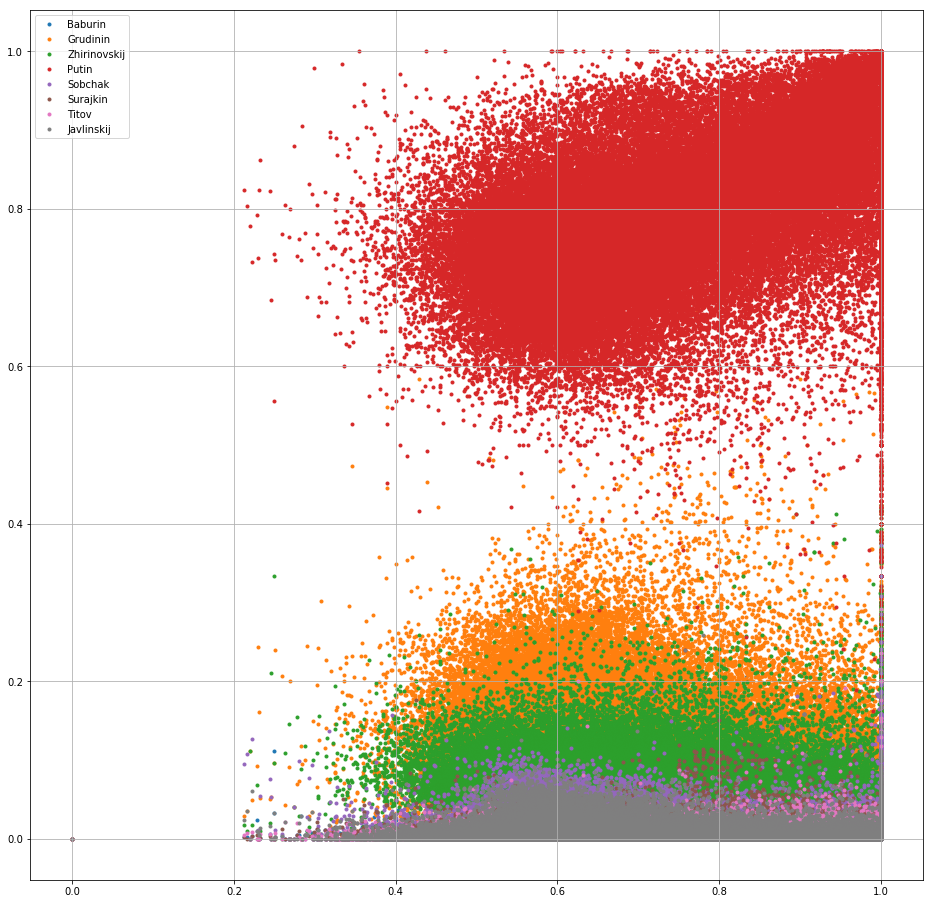

In [254]:
plt.figure(figsize=(16, 16))
plt.scatter(turnout, baburin, marker='.', label='Baburin')
plt.scatter(turnout, grudinin, marker='.', label='Grudinin')
plt.scatter(turnout, zhirinovskij, marker='.', label='Zhirinovskij')
plt.scatter(turnout, putin, marker='.', label='Putin')
plt.scatter(turnout, sobchak, marker='.', label='Sobchak')
plt.scatter(turnout, surajkin, marker='.', label='Surajkin')
plt.scatter(turnout, titov, marker='.', label='Titov')
plt.scatter(turnout, javlinskij, marker='.', label='Javlinskij')
plt.grid()
plt.legend(loc='best')
plt.show()

### TODO

* Деление на ноль на некоторых УИКах